In [151]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt

n_pristine = [6912,6912]
num_elem = len(n_pristine)
concentration_pristine = [float(n)/sum(n_pristine) for n in n_pristine]
Tlist = [4040, 3640]


from matplotlib.pyplot import cm
clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]
font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 18
}

/tmp/ipykernel_2524714/1037784285.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]


In [152]:
def read_kernel(dirname):
    filename = os.path.join(dirname, "aveS0.dat")
    with open(filename,"r") as fp:
        fp.readline()
        fp.readline()
        fp.readline()
        s0CC,covs0CC = tuple([float(x) for x in fp.readline().split()])
        s0HfC,covs0HfC = tuple([float(x) for x in fp.readline().split()])
        s0HfHf,covs0HfHf = tuple([float(x) for x in fp.readline().split()])
    return s0CC, covs0CC

In [153]:
def read_lammpstrj(filedesc):
    # three comment lines
    for i in range(3): comment = filedesc.readline()
    # number of atoms
    natoms = int(filedesc.readline())

    # 1 comment line
    comment = filedesc.readline()
    # assume orthorombic cell
    cell = np.zeros(3,float)
    for i in range(3):
        # [cellmin, cellmax] = filedesc.readline().split()
        linec = filedesc.readline().split()
        cellmin = linec[0]
        cellmax = linec[1]
        cell[i] = float(cellmax) - float(cellmin)

    # 1 comment line
    comment = filedesc.readline()
    names = np.zeros(natoms,'U2')
    q = np.zeros((natoms,3),float)
    sq = np.zeros((natoms,3),float)

    for i in range(natoms):
        line = filedesc.readline().split();
        names[i] = line[1] # atom type
        q[i] = line[2:5] # wrapped atomic coordinates
        sq[i,0] = float(q[i,0])/cell[0] # scaled atomic coordinates
        sq[i,1] = float(q[i,1])/cell[1] # scaled atomic coordinates
        sq[i,2] = float(q[i,2])/cell[2] # scaled atomic coordinates
    return [cell, names, sq]

In [154]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian

In [155]:
def cofactor(B):
    return (np.linalg.inv(B)).T * np.linalg.det(B)


In [156]:
def fillDmat(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = np.eye(rank)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

def fillDmat_(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = torch.eye(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

In [157]:
def fillapproxGmat(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-np.eye(rank,rank)/0.04
    return Gmat

def fillapproxGmat_(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-torch.eye(rank,rank).to(torch.float64)/0.04
    return Gmat

In [158]:
def KBI_mu(x_, Smat_, elem=0):
    rank = x_.shape[0]
    Smat_ = Smat_.reshape(rank, rank)
    approx_Gmat = fillapproxGmat_(Smat_)
    print("            Smat = ")
    print(Smat_.detach().numpy())
    # print("Approximate Gmat = ", approx_Gmat[0,0], approx_Gmat[1,1], approx_Gmat[0,1], approx_Gmat[1,0])
    # Smat_ = torch.from_numpy(Smat).requires_grad_()
    
    # Gmat = fillGmat(c, Smat)
    # Bmat = fillBmat(c, Gmat)
    # Dmat = fillDmat(x,Smat)
    Dmat_ = fillDmat_(x_,Smat_)
    # tiDmat = np.linalg.inv(Dmat).T
    tiDmat_ = torch.linalg.inv(Dmat_).T
    # Kai_NPT = np.zeros([rank,rank])
    Kai_NPT_ = torch.zeros([rank,rank], dtype=torch.float64)
    # x_ = torch.from_numpy(x).requires_grad_()
    for i in range(rank):
        for j in range(rank):
            s1 = 0.0
            s2 = 0.0
            s3 = 0.0
            for k in range(rank):
                s1 += tiDmat_[k][i]
                s2 += tiDmat_[k][j]
                for h in range(rank):
                    s3 += x_[h]*tiDmat_[k][h]
            Kai_NPT_[i][j] = tiDmat_[i][j]/x_[i] - s1*s2/s3
    # print("Kai_NPT     = ",Kai_NPT_)
    Kai_NPT_lnx_ = torch.zeros(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i==j: 
                Kai_NPT_lnx_[i] += Kai_NPT_[i][i]*x_[i]
            else:
                Kai_NPT_lnx_[i] -= Kai_NPT_[i][j]*x_[i]
    # print("Kai_NPT_inx = ", Kai_NPT_lnx_)
    
    Kai_NPT_00_a = 1./(x_[1]*Smat_[0][0]+x_[0]*Smat_[1][1]-2*torch.sqrt(x_[0]*x_[1])*Smat_[0][1])  
    print("!!!!!! checking:: ", (x_[1]*Smat_[0][0]+x_[0]*Smat_[1][1]-2*torch.sqrt(x_[0]*x_[1])*Smat_[0][1]), Kai_NPT_00_a) 
    assert math.isclose(Kai_NPT_lnx_[0].detach().numpy(), Kai_NPT_00_a.detach().numpy(), abs_tol =  1e-4), print(Kai_NPT_lnx_[0].detach().numpy(), Kai_NPT_00_a.detach().numpy())
    return Kai_NPT_lnx_[elem]

In [159]:
num_Vlist = [29, 58, 108, 174, 216, 348, 432, 580, 648]
frac_C = [1-i/6912.0 for i in num_Vlist]


In [160]:
Kai_NPT_lnx_list = []
Kai_NPT_lnx1_list = []
std_Kai_NPT_lnx_list = []
# order2_std_Kai_NPT_lnx_list = []
s0CC_list = []
s0HfC_list = []
s0HfHf_list = []
for idx_T, T in enumerate(Tlist):
    Kai_NPT_lnx_list.append([])
    Kai_NPT_lnx1_list.append([])
    std_Kai_NPT_lnx_list.append([])
    # order2_std_Kai_NPT_lnx_list.append([])
    s0CC_list.append([])
    s0HfC_list.append([])
    s0HfHf_list.append([])
    for idx_num_V, num_V in enumerate(num_Vlist):
        num_V1 = num_V
        dirname = "Vc%d/T%d/testmctemp-%d"%(num_V1, T, T*3)
        s0CC, cov_s0CC = read_kernel(dirname)
        s0CC_list[-1].append(s0CC)

        x = 1-num_V1/6912.0
        print("Number of C vacancies =", num_V1)
        # print("Number of atoms =", n_system)
        print("Mole fraction of atoms in the system =",x)

        Smat = np.array([s0CC])
        std_Smat = np.sqrt(cov_s0CC)
        # print("   std_Smat = ", std_Smat)
        varmat_Smat = std_Smat*std_Smat
        # print("varmat_Smat = ")
        # print(varmat_Smat)

        Smat_ = torch.from_numpy(Smat.reshape(-1)).to(dtype=torch.float64).requires_grad_()
        x_ = torch.tensor(x).to(torch.float64).requires_grad_(False)
        
        Kai_NPT_lnx_0 = 1.0/Smat_
        print("Kai_NPT_lnx = ", Kai_NPT_lnx_0)

        Kai_NPT_lnx_list[-1].append(Kai_NPT_lnx_0.detach().numpy())
        print("\n")
        

Number of C vacancies = 29
Mole fraction of atoms in the system = 0.9958043981481481
Kai_NPT_lnx =  tensor([50.0302], dtype=torch.float64, grad_fn=<MulBackward0>)


Number of C vacancies = 58
Mole fraction of atoms in the system = 0.9916087962962963
Kai_NPT_lnx =  tensor([47.7180], dtype=torch.float64, grad_fn=<MulBackward0>)


Number of C vacancies = 108
Mole fraction of atoms in the system = 0.984375
Kai_NPT_lnx =  tensor([40.7900], dtype=torch.float64, grad_fn=<MulBackward0>)


Number of C vacancies = 174
Mole fraction of atoms in the system = 0.9748263888888888
Kai_NPT_lnx =  tensor([34.8187], dtype=torch.float64, grad_fn=<MulBackward0>)


Number of C vacancies = 216
Mole fraction of atoms in the system = 0.96875
Kai_NPT_lnx =  tensor([30.4223], dtype=torch.float64, grad_fn=<MulBackward0>)


Number of C vacancies = 348
Mole fraction of atoms in the system = 0.9496527777777778
Kai_NPT_lnx =  tensor([22.5767], dtype=torch.float64, grad_fn=<MulBackward0>)


Number of C vacancies = 432

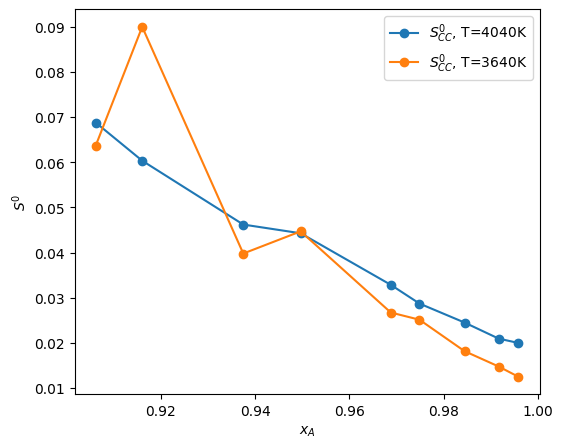

In [161]:
plt.rcParams["figure.figsize"] = (6,5)
xlist = frac_C
for idx_T, T in enumerate(Tlist):
    plt.plot(xlist, s0CC_list[idx_T], marker="o", label="$S^0_{CC}$, T=%dK"%T)

plt.xlabel("$x_A$")
plt.ylabel("$S^0$")
plt.legend()

In [162]:
Kai_NPT_lnx_list = np.array(Kai_NPT_lnx_list)
import dpdata

totalatom = 23328
c_A_list = []
N_A_list = []

Volume_list = []
for idx_T, T in enumerate(Tlist):
    c_A_list.append([])
    Volume_list.append([])
    for idx_num_V, num_V in enumerate(num_Vlist):
        dirname = "Vc%d/T%d/testmctemp-%d"%(num_V, T, T*3)
        print(dirname)
        filename = os.path.join(dirname, "thermo-prod.dat")
        length_data = len(open(filename,"r").readlines())
        Volume_data = np.loadtxt(filename, skiprows=length_data-300).T[12]
        Volume = np.mean(Volume_data)
        Volume_list[-1].append(Volume)
        if T == 3640 and num_V in [29, 58, 108, 216, 432, 648]:
            conf = dpdata.System(os.path.join(dirname, "bk007.nosehoover/conf.lmp"), "lammps/lmp")
        else:
            conf = dpdata.System(os.path.join(dirname, "bk000.nosehoover/conf.lmp"), "lammps/lmp")
        N_A_list.append(conf["atom_numbs"][2])
        c_A = conf["atom_numbs"][2]/Volume
        c_A_list[-1].append(c_A)

        
        print(int(np.ceil(totalatom*num_V1)), conf["atom_numbs"][0])
        # assert int(np.ceil(totalatom*num_V1)) == conf["atom_numbs"][0]
        # assert int(totalatom-np.ceil(totalatom*num_V1)) == conf["atom_numbs"][1]
c_A_list = np.array(c_A_list)
Volume_list = np.array(Volume_list)
N_A_list = np.array(N_A_list)


print(c_A_list)
print(totalatom)

Vc29/T4040/testmctemp-12120
15116544 6912
Vc58/T4040/testmctemp-12120
15116544 6912
Vc108/T4040/testmctemp-12120
15116544 6912
Vc174/T4040/testmctemp-12120
15116544 6912
Vc216/T4040/testmctemp-12120
15116544 6912
Vc348/T4040/testmctemp-12120
15116544 6912
Vc432/T4040/testmctemp-12120
15116544 6912
Vc580/T4040/testmctemp-12120
15116544 6912
Vc648/T4040/testmctemp-12120
15116544 6912
Vc29/T3640/testmctemp-10920
15116544 6912
Vc58/T3640/testmctemp-10920
15116544 6912
Vc108/T3640/testmctemp-10920
15116544 6912
Vc174/T3640/testmctemp-10920
15116544 6912
Vc216/T3640/testmctemp-10920
15116544 6912
Vc348/T3640/testmctemp-10920
15116544 6912
Vc432/T3640/testmctemp-10920
15116544 6912
Vc580/T3640/testmctemp-10920
15116544 6912
Vc648/T3640/testmctemp-10920
15116544 6912
[[0.03677847 0.03663843 0.03636426 0.0360241  0.03582453 0.03509977
  0.03464699 0.03383283 0.03345065]
 [0.03728529 0.03715032 0.03688353 0.03651813 0.03628842 0.03556783
  0.03509549 0.03428153 0.0339035 ]]
23328


[29, 58, 108, 174, 216, 348, 432, 580, 648]
[0.9958044  0.9916088  0.984375   0.97482639 0.96875    0.94965278
 0.9375     0.91608796 0.90625   ]


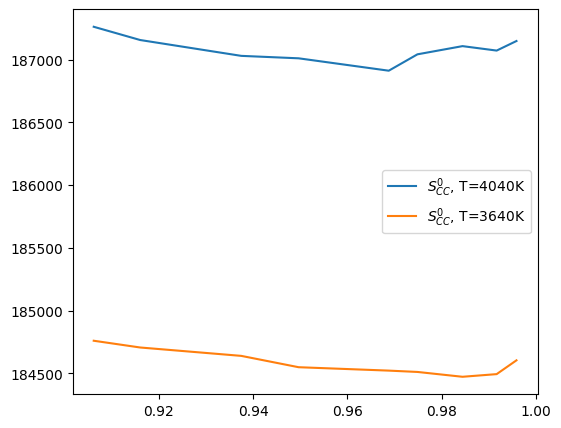

In [163]:
x = np.array(frac_C)
lnx = np.log(x).reshape(-1,1)
print(num_Vlist)
print(x)
for idx_T, T in enumerate(Tlist):
    plt.plot(x, Volume_list[idx_T], label="$S^0_{CC}$, T=%dK"%T)
plt.legend()

In [164]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.integrate import quad
gp_list = []
y_gp_list = []
std_y_gp_list = []
for idx_T, T in enumerate(Tlist):
    kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(lnx.reshape(-1,1), Kai_NPT_lnx_list[idx_T].reshape(-1,1))
    gp_list.append(gp)
    y_gp, std_y_gp = gp.predict(lnx.reshape(-1,1), return_std=True)
    y_gp_list.append(y_gp)
    std_y_gp_list.append(std_y_gp)


/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


/tmp/ipykernel_2524714/666872862.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, Kai_NPT_lnx_list[idx_T], label=f"T={T}", c=clist[idx_T])


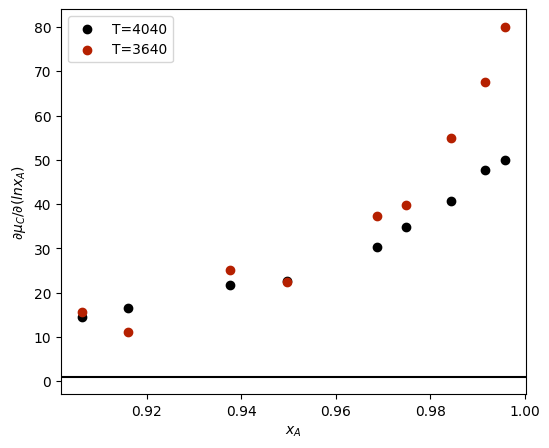

In [165]:
plt.rcParams["figure.figsize"] = (6,5)

# plt.scatter(x, Kai_NPT_lnx_list[0], marker="o", label="A")
# plt.scatter(x, y_gp, marker="*", label="A")
# plt.fill_between(x, y_gp+std_y_gp, y_gp-std_y_gp, label="A")
for idx_T, T in enumerate(Tlist):
    plt.scatter(x, Kai_NPT_lnx_list[idx_T], label=f"T={T}", c=clist[idx_T])

plt.xlabel("$x_A$")
plt.ylabel("$\partial \mu_C/\partial (lnx_A) $")
plt.legend()
plt.axhline(1, c="k")


In [166]:
plt.rcParams["figure.figsize"] = (6,5)
from scipy.integrate import trapz
lnx = lnx.reshape(-1)
integral_gp_list = []
baseline_list = []
for idx_T, T in enumerate(Tlist):
    y_gp = y_gp_list[idx_T]
    integral_gp = np.cumsum([0]+[(y_gp[i]+y_gp[i+1])/2*(lnx[i+1]-lnx[i]) for i in range(len(lnx)-2)])
    integral_gp_list.append(integral_gp)

    print("x-variable::")
    print(x)

    print("lnx-variable::")
    print(lnx)

    print("Integrand:: ")
    print(y_gp)

    print("Integral cumsum")
    print(integral_gp)


    # baseline = np.cumsum([-(1)*(lnc[i]-lnc[i-1]) for i in range(len(lnc)-1, 0, -1)])
    # baseline1 = np.cumsum([-(1)*(lnc1[i+1]-lnc1[i]) for i in range(len(lnc1)-1)])
    baseline = -np.array([lnx[i]-lnx[0] for i in range(len(lnx)-1)])
    baseline_list.append(baseline)

    print("baseline")
    print(baseline)

    print("excess")
    print((integral_gp+baseline))


x-variable::
[0.9958044  0.9916088  0.984375   0.97482639 0.96875    0.94965278
 0.9375     0.91608796 0.90625   ]
lnx-variable::
[-0.00420443 -0.00842661 -0.01574836 -0.02549589 -0.0317487  -0.05165886
 -0.06453852 -0.08764289 -0.09844007]
Integrand:: 
[50.03020147 47.71801757 40.79003151 34.81873895 30.42231078 22.57674101
 21.63496787 16.56579246 14.53509379]
Integral cumsum
[ 0.         -0.20635529 -0.53037214 -0.8988715  -1.10284151 -1.63045131
 -1.91516726 -2.35646948]
baseline
[-0.          0.00422218  0.01154393  0.02129146  0.02754427  0.04745443
  0.06033409  0.08343846]
excess
[ 0.         -0.20213311 -0.51882821 -0.87758005 -1.07529724 -1.58299688
 -1.85483317 -2.27303102]
x-variable::
[0.9958044  0.9916088  0.984375   0.97482639 0.96875    0.94965278
 0.9375     0.91608796 0.90625   ]
lnx-variable::
[-0.00420443 -0.00842661 -0.01574836 -0.02549589 -0.0317487  -0.05165886
 -0.06453852 -0.08764289 -0.09844007]
Integrand:: 
[80.042276   67.67595932 55.01229585 39.77398876 37.

0.004222179963810061
0.011543928882611803
0.021291458431866056
0.027544270229052932
0.047454430188382656
0.06033409305204381
0.08343846139746136
0.004222179963810061
0.011543928882611803
0.021291458431866056
0.027544270229052932
0.047454430188382656
0.06033409305204381
0.08343846139746136


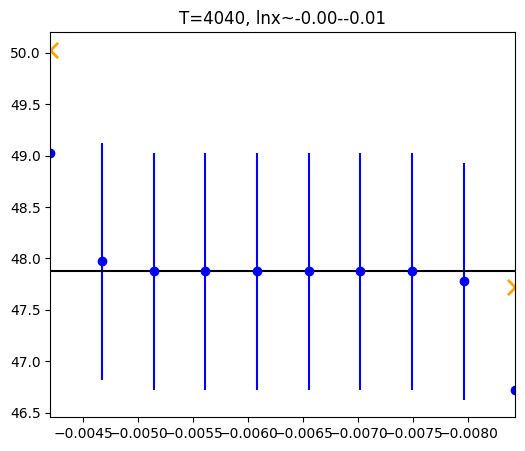

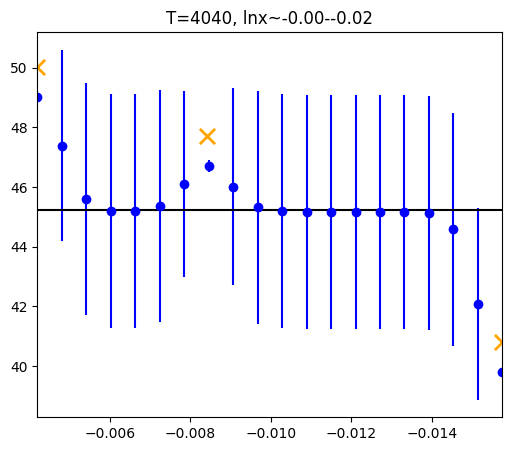

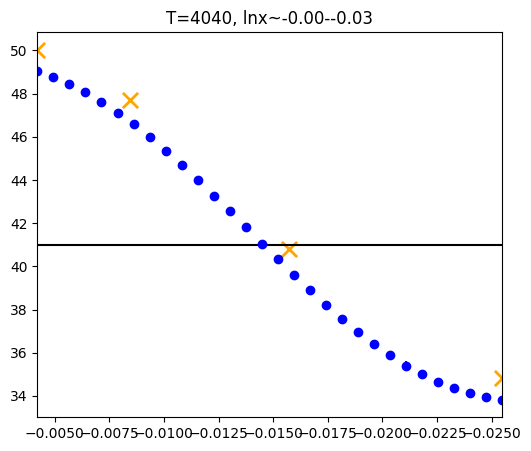

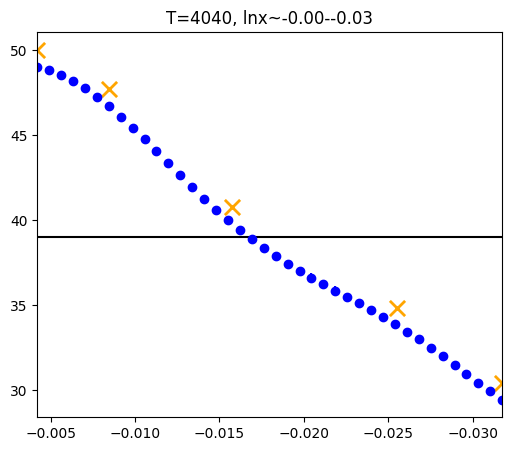

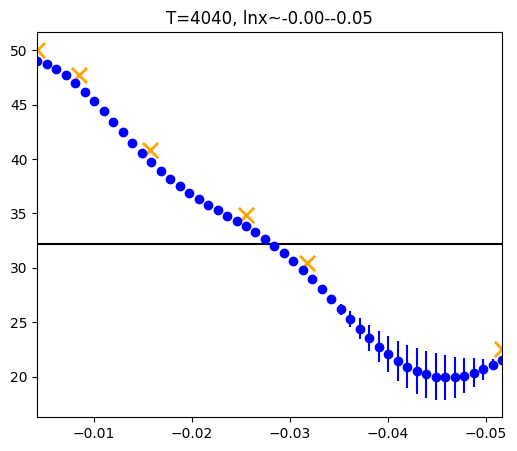

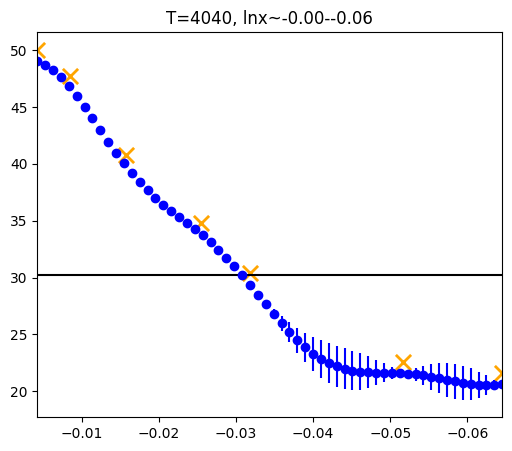

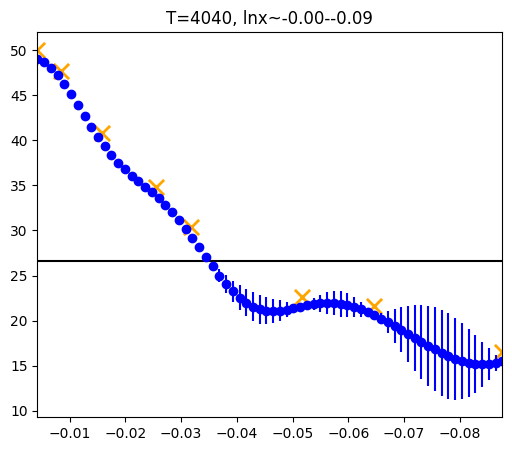

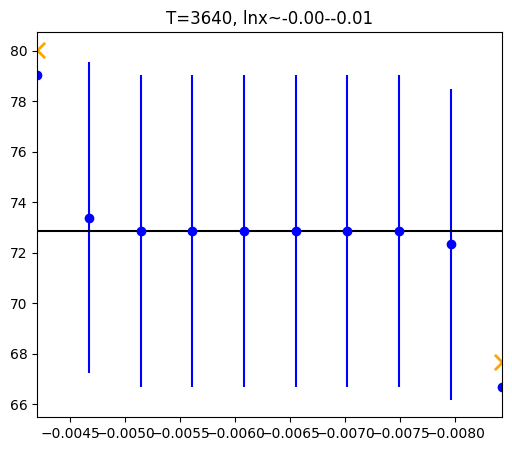

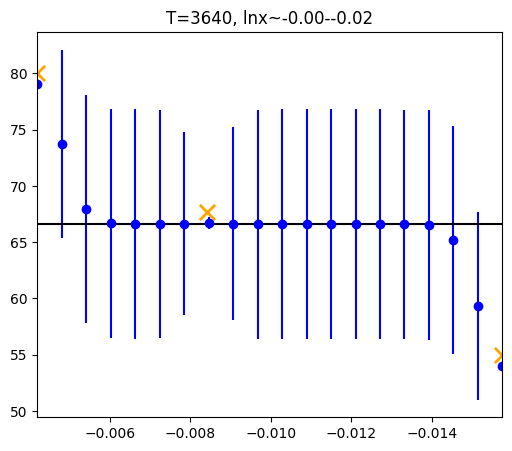

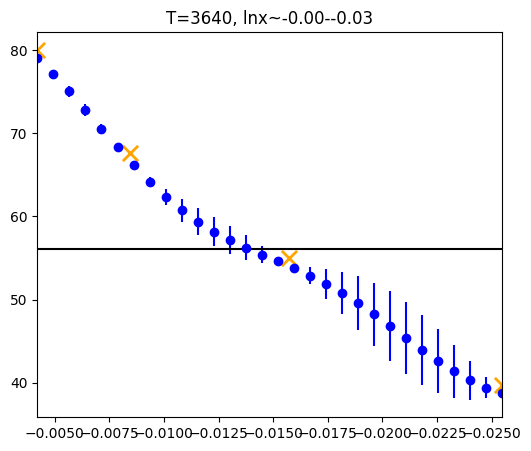

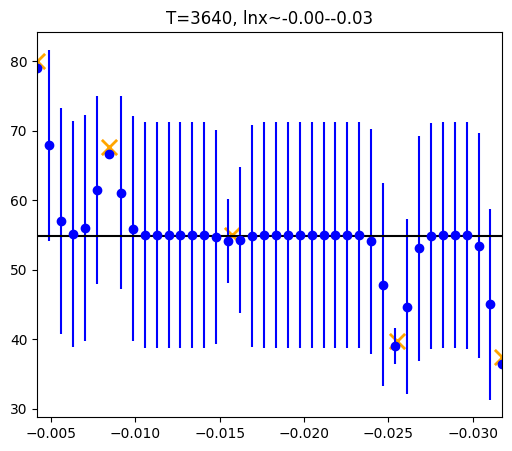

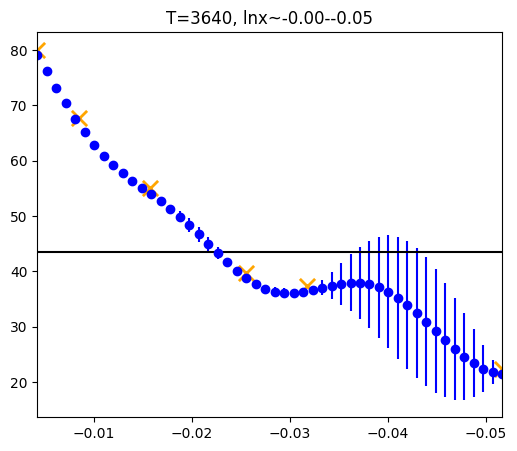

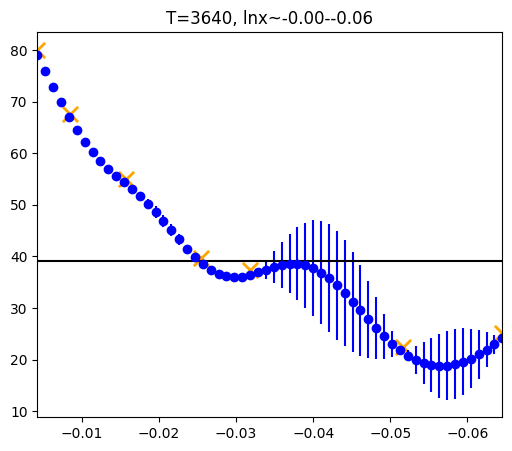

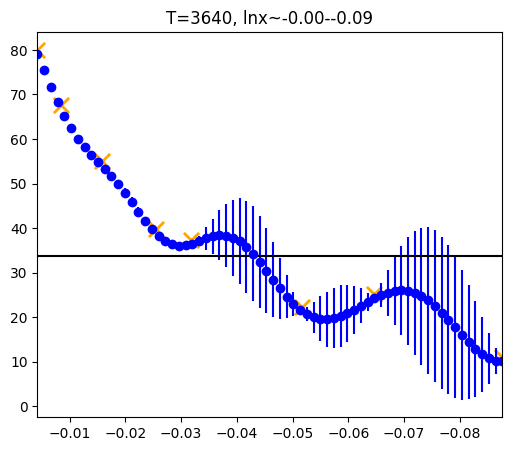

In [182]:
# integral by MC
MCintegral_gp_list = []
MCintegral_gp_std_list = []
for idx_T, T in enumerate(Tlist):
    lnx = lnx.reshape(-1)
    MCintegral_gp = [0]
    MCintegral_gp_std = [0]
    # gp = gp_list[idx_T]
    
    for i in range(len(lnx)-2):
        min_lnx = lnx[0]
        max_lnx = lnx[i+1]
        area_lnx = (max_lnx-min_lnx)
        MC_x_samples = np.linspace(min_lnx, max_lnx, 10*(i+1))
        mean_Kai = np.mean(Kai_NPT_lnx_list[idx_T][:i+2])
        print(np.abs(area_lnx))
        kernel = 1.0 * RBF(length_scale=0.05*np.abs(area_lnx))
        gp = GaussianProcessRegressor(kernel=kernel)
        gp.fit(lnx[:i+2].reshape(-1,1), Kai_NPT_lnx_list[idx_T][:i+2].reshape(-1,1)-mean_Kai)

        MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)
        MC_y_samples -= 1.
        MC_y_average = np.mean(MC_y_samples.reshape(-1))
        # MC_y_std = max(np.max(std_MC_y_samples.reshape(-1)), std_Kai_NPT_lnx_list[0][i+1])/np.sqrt(100*(i+1))
        MC_y_std = np.max(std_MC_y_samples.reshape(-1))/np.sqrt(10*(i+1))
        MCintegral_gp.append((MC_y_average+mean_Kai)*(area_lnx))
        MCintegral_gp_std.append(MC_y_std*np.abs(area_lnx))
        plt.figure()
        plt.errorbar(np.linspace(min_lnx, max_lnx, 10*(i+1)), MC_y_samples+mean_Kai, std_MC_y_samples, c="blue", fmt='o', linestyle='None')
        plt.scatter(lnx[:i+2], Kai_NPT_lnx_list[idx_T][:i+2], marker="x", c="orange", s=120, linewidths=2)
        plt.axhline(MC_y_average+mean_Kai, c="k")
        plt.xlim((min_lnx, max_lnx))
        plt.title("T=%d, lnx~%.2f-%.2f"%(T, min_lnx, max_lnx))

    MCintegral_gp = np.array(MCintegral_gp)
    MCintegral_gp_std = np.array(MCintegral_gp_std)
    MCintegral_gp_list.append(MCintegral_gp)
    MCintegral_gp_std_list.append(MCintegral_gp_std)



[0.9958044  0.9916088  0.984375   0.97482639 0.96875    0.94965278
 0.9375     0.91608796 0.90625   ]


/tmp/ipykernel_2524714/4033333726.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:-1], (integral_gp+baseline), label="$\mu^{ex}_A$ ($k_BT$): Integral by trapez., T%d"%T, c=clist[idx_T], marker="x")


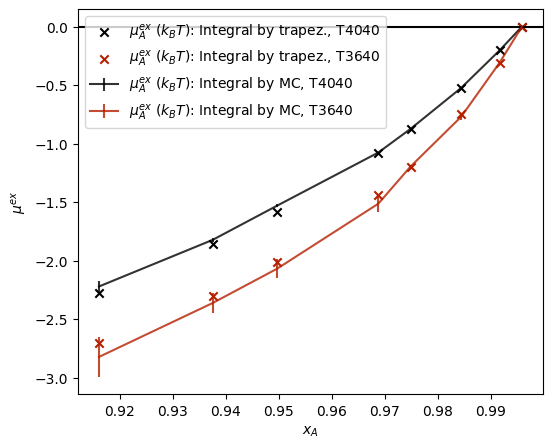

In [183]:
print(x)
for idx_T, T in enumerate(Tlist):
    integral_gp = integral_gp_list[idx_T]
    baseline = baseline_list[idx_T]
    MCintegral_gp = MCintegral_gp_list[idx_T]
    MCintegral_gp_std = MCintegral_gp_std_list[idx_T]
    plt.scatter(x[:-1], (integral_gp+baseline), label="$\mu^{ex}_A$ ($k_BT$): Integral by trapez., T%d"%T, c=clist[idx_T], marker="x")
    plt.errorbar(x[:-1], MCintegral_gp, MCintegral_gp_std, color=clist[idx_T], alpha=0.8, label="$\mu^{ex}_A$ ($k_BT$): Integral by MC, T%d"%T)
plt.axhline(0, c="k")
plt.ylabel("$\mu^{ex}$")
plt.xlabel("$x_A$")
plt.legend()


[0.9958044  0.9916088  0.984375   0.97482639 0.96875    0.94965278
 0.9375     0.91608796 0.90625   ]


/tmp/ipykernel_2524714/4086432194.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:-1], ((integral_gp+baseline)-(integral_gp+baseline)[0])*T/298.*2.074, label="$\mu^{ex}_A$ ($eV$): Integral by trapez., T%d"%T, c=clist[idx_T], marker="x")


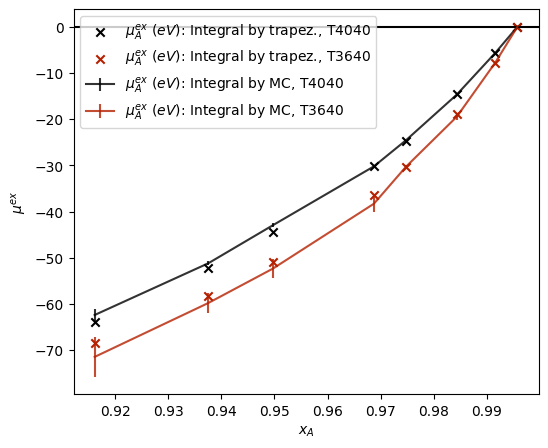

In [184]:
print(x)
for idx_T, T in enumerate(Tlist):
    integral_gp = integral_gp_list[idx_T]
    baseline = baseline_list[idx_T]
    MCintegral_gp = MCintegral_gp_list[idx_T]
    MCintegral_gp_std = MCintegral_gp_std_list[idx_T]
    plt.scatter(x[:-1], ((integral_gp+baseline)-(integral_gp+baseline)[0])*T/298.*2.074, label="$\mu^{ex}_A$ ($eV$): Integral by trapez., T%d"%T, c=clist[idx_T], marker="x")
    plt.errorbar(x[:-1], (MCintegral_gp-MCintegral_gp[0])*T/298.*2.074, MCintegral_gp_std*T/298.*2.074, color=clist[idx_T], alpha=0.8, label="$\mu^{ex}_A$ ($eV$): Integral by MC, T%d"%T)
plt.axhline(0, c="k")
plt.ylabel("$\mu^{ex}$")
plt.xlabel("$x_A$")
plt.legend()

[0.9958044  0.9916088  0.984375   0.97482639 0.96875    0.94965278
 0.9375     0.91608796 0.90625   ]


/tmp/ipykernel_2524714/888385799.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:-1], ((integral_gp+baseline)-(integral_gp+baseline)[0])*0.00198717*T, label="$\mu^{ex}_A$ ($kcal/mol$): Integral by trapez., T%d"%T, c=clist[idx_T], marker="x")


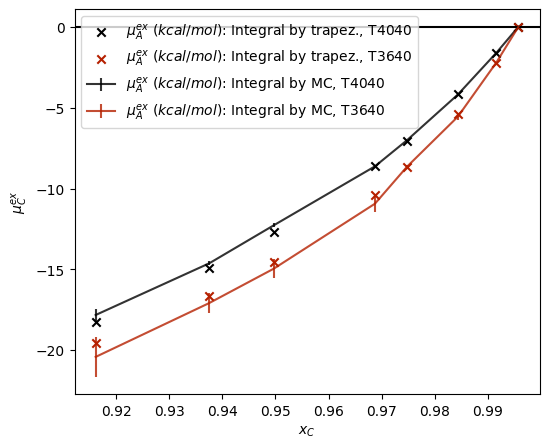

In [185]:
print(x)
for idx_T, T in enumerate(Tlist):
    integral_gp = integral_gp_list[idx_T]
    baseline = baseline_list[idx_T]
    MCintegral_gp = MCintegral_gp_list[idx_T]
    MCintegral_gp_std = MCintegral_gp_std_list[idx_T]
    plt.scatter(x[:-1], ((integral_gp+baseline)-(integral_gp+baseline)[0])*0.00198717*T, label="$\mu^{ex}_A$ ($kcal/mol$): Integral by trapez., T%d"%T, c=clist[idx_T], marker="x")
    plt.errorbar(x[:-1], (MCintegral_gp-MCintegral_gp[0])*0.00198717*T, MCintegral_gp_std*0.00198717*T, color=clist[idx_T], alpha=0.8, label="$\mu^{ex}_A$ ($kcal/mol$): Integral by MC, T%d"%T)
plt.axhline(0, c="k")
plt.ylabel("$\mu^{ex}_C$")
plt.xlabel("$x_C$")
plt.legend()

In [171]:
print("4040K to kJ/mol:", 4040./298.*2.074)
print("4040K to eV:", 4040./300.*0.0259)
print("4040K to kcal/mol:", 0.00198717*4040)

4040K to kJ/mol: 28.117315436241608
4040K to eV: 0.3487866666666667
4040K to kcal/mol: 8.0281668
